<a href="https://colab.research.google.com/github/AdindaRahajengSilviaPranesti/MarchineLearning_2141720158_AdindaRSP_02/blob/main/Week10RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🖥 **Job Sheet 10: RNN**
####- **🌼Adinda Rahajeng Silvia Pranesti🌼**
###- **🌼2141720158 / 02**
###- **🌼3I-TI**

##**🖥LAB WORK 1**
**RNN for Sentiment Analysis**

**Setup**

Import matplotlib and create a helper function to plot the graph:

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

**Setup input pipeline**

The IMDB movie review dataset is a binary classification dataset—all reviews have either positive or negative sentiment.
Download the dataset using TFDS.

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Initially, this returns a dataset (text, label pairs):
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# Next, shuffle the data for training and create this pair dataset:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"One of my sisters friends lent me this game, and it is too damn hard! It carries the appearance of a kids game, but you have to learn how to do tons of intricate moves that require you to twist and turn your hands into all sorts of awkward positions, and you have to search seemingly endless levels for 100 notes, to improve your 'score'! You also have to find these impossibly hidden jigsaw puzzle pieces, that require you to do almost impossible tasks to get them! AND I AM ONLY UP TO STAGE THREE!!!!! Maybe if you have no life nad can stay home all the time you might get some enjoyment out of this, but otherwise keep away! AND IT IS DEFINATELY NOT RECOMMENDED FOR KIDS - THEY WILL PULL THEIR HAIR OUT WITHIN THE HOUR!"
 b'There are a few spoilers in this comment!!<br /><br />Contrary to the comments I just read by nativetex4u and a few others, I really liked the movie and would love to see it as a weekly series.<br /><br />I am a Judson Mills fan but also a huge Chuck Norris fan 

**Create a Text Encoder**


Raw text loaded by tfds needs to be processed before it can be used in a model. The easiest way to preprocess text for training is to use the TextVectorization layer. This layer has many capabilities, but in this tutorial, we are using the default behavior. Create this layer and pass the text dataset to the layer's .adapt method:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# After padding and unknown tokens, they are sorted by frequency:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
# The index tensor is padded with 0s to the longest sequence in the batch (unless if you set output_sequence_length fixed):
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  20,  44, ...,   0,   0,   0],
       [ 10,  41, 208, ...,   0,   0,   0],
       [ 11,  59,  26, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"One of my sisters friends lent me this game, and it is too damn hard! It carries the appearance of a kids game, but you have to learn how to do tons of intricate moves that require you to twist and turn your hands into all sorts of awkward positions, and you have to search seemingly endless levels for 100 notes, to improve your 'score'! You also have to find these impossibly hidden jigsaw puzzle pieces, that require you to do almost impossible tasks to get them! AND I AM ONLY UP TO STAGE THREE!!!!! Maybe if you have no life nad can stay home all the time you might get some enjoyment out of this, but otherwise keep away! AND IT IS DEFINATELY NOT RECOMMENDED FOR KIDS - THEY WILL PULL THEIR HAIR OUT WITHIN THE HOUR!"


NameError: ignored

##**Create a Model**

In [ ]:
#STEP 1
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
# step 2
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# step 3
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 10s 10s/step
[0.00342579]


In [ ]:
# step 4
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 60ms/step
[0.00342579]


In [ ]:
# Compile the Keras model to configure the training process:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

##**Train Model**

In [ ]:
#step 1
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 48s 96ms/step - loss: 0.6411 - accuracy: 0.5675 - val_loss: 0.4834 - val_accuracy: 0.7214
Epoch 2/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3941 - accuracy: 0.8200 - val_loss: 0.3669 - val_accuracy: 0.8245
Epoch 3/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3379 - accuracy: 0.8509 - val_loss: 0.3468 - val_accuracy: 0.8349
Epoch 4/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3230 - accuracy: 0.8587 - val_loss: 0.3646 - val_accuracy: 0.8276
Epoch 5/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3127 - accuracy: 0.8636 - val_loss: 0.3382 - val_accuracy: 0.8568
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3091 - accuracy: 0.8666 - val_loss: 0.3288 - val_accuracy: 0.8589
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3044 - accuracy: 0.8688 - val_loss: 0.3228 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3171 - accuracy: 0.8623
Test Loss: 0.31709960103034973
Test Accuracy: 0.862280011177063


(0.0, 0.6582980364561081)

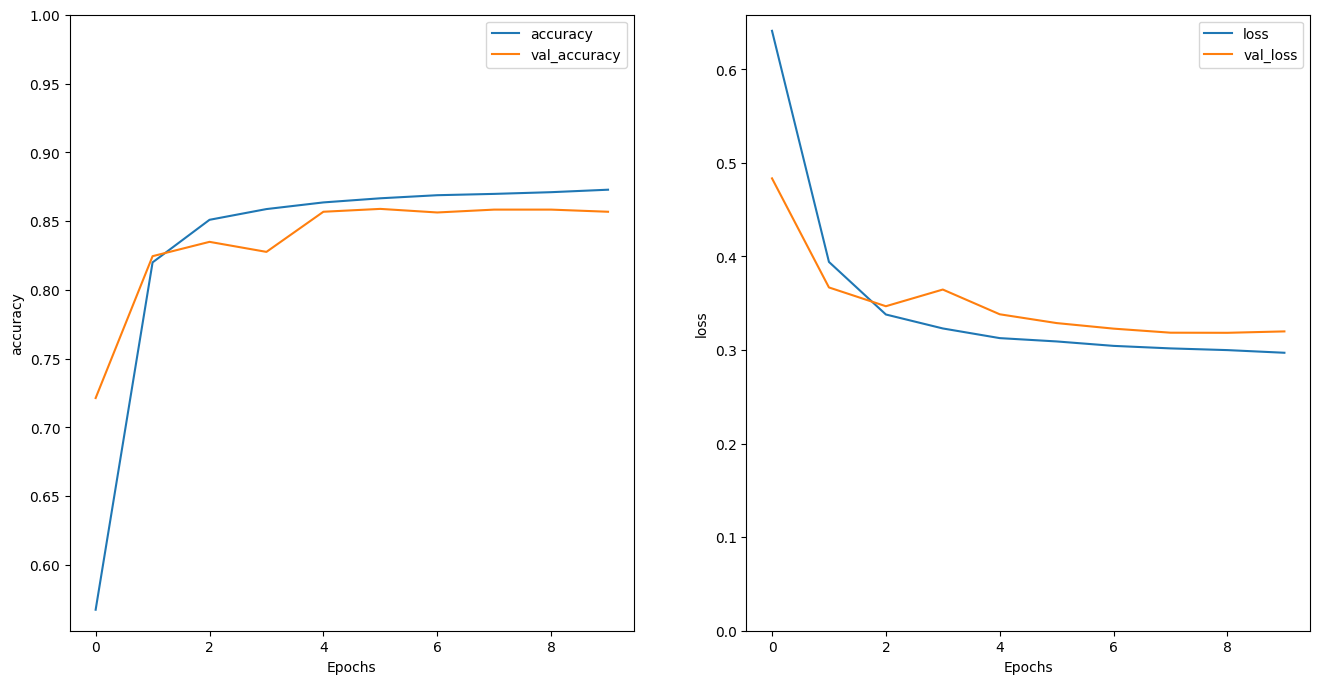

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run predictions on a new sentence: If the prediction is >= 0.0, it's positive; otherwise, it's negative.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


One interesting aspect of using RNNs with return_sequences=True is that the output still has 3 axes, just like the input, so it can be passed to other RNN layers, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 152ms/step - loss: 0.6300 - accuracy: 0.5850 - val_loss: 0.4319 - val_accuracy: 0.8073
Epoch 2/10
391/391 [==============================] - 46s 116ms/step - loss: 0.3812 - accuracy: 0.8313 - val_loss: 0.3497 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3360 - accuracy: 0.8545 - val_loss: 0.3400 - val_accuracy: 0.8458
Epoch 4/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3198 - accuracy: 0.8635 - val_loss: 0.3211 - val_accuracy: 0.8547
Epoch 5/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3099 - accuracy: 0.8668 - val_loss: 0.3194 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3061 - accuracy: 0.8682 - val_loss: 0.3200 - val_accuracy: 0.8609
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3051 - accuracy: 0.8687 - val_loss: 0.3243 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 50ms/step - loss: 0.3201 - accuracy: 0.8626
Test Loss: 0.3201315701007843
Test Accuracy: 0.8626400232315063


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
              'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.760184]]


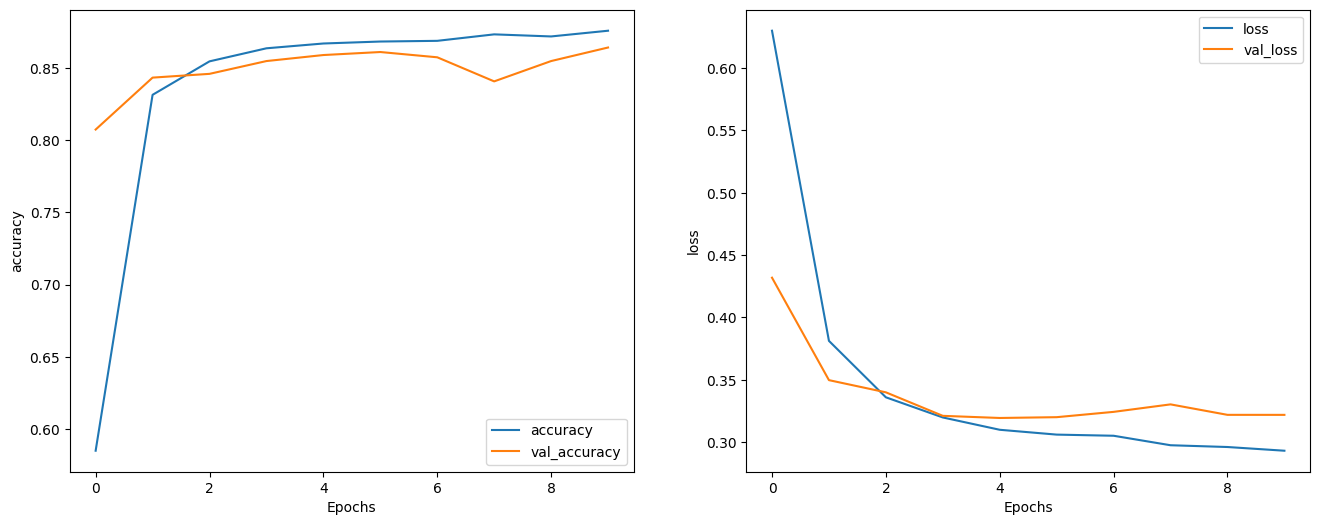

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

##**🖥LAB WORK 2**
**Text Generator with RNN**

**Setup**


Import TenserFlow

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

**Download Dataset Shakespeare**


Adjust to the location of the data you have.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


**Load Data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Text Processing**


**Vectorize Text**


Before training, you need to convert the string into a numeric representation. tf.keras.layers.StringLookup can convert each character to a numeric ID. The way this is done is by first breaking the text into tokens.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
#Now create the tf.keras.layers.StringLookup layer:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [ ]:
# The above command converts tokens into IDs.
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
# Since the goal of this tutorial is to generate text, it's also important to reverse this representation. For this, you can use the tf.keras.layers.StringLookup(..., invert=True) code.
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
# This layer converts characters back from the ID vector and returns them as a tf.RaggedTensor:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
# You can use tf.strings.reduce_join to recombine characters into a string.
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

###**Prediction**
**Creating the Training Set and Target**

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

The batch method allows you to easily convert these individual characters into a desired size sequence.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())


AttributeError: ignored

For training, you need a dataset of pairs (input, label), where input and label are sequences. At each time step, the input is the current character, and the label is the next character. Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each time step:

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

AttributeError: ignored

**Creating Batch Training**

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Create a Model**

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [61]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Test the Model**

In [62]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [63]:
model.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  16896     
                                                                 
 gru_1 (GRU)                 multiple                  3938304   
                                                                 
 dense_5 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
sampled_indices =tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [66]:
# This gives us, at each time step, the predicted index of the next character:
sampled_indices

array([65, 29, 36, 53,  6,  0, 40, 34, 41, 28, 42, 39,  2, 42, 36, 49, 13,
       23, 29, 54, 30, 31, 57,  9,  0, 45, 40, 49, 48, 32, 51, 55, 59,  2,
       60, 29, 46, 45,  5, 39, 33, 39, 20, 27, 49, 46, 26, 25, 49,  7,  9,
       58,  6, 48, 26, 36, 21, 37, 47,  1, 54, 21, 29, 28, 51,  7, 19, 26,
       10, 22, 33,  6, 24, 46,  6, 63, 43, 40, 58, 45, 52, 38,  1, 18, 42,
       10, 61, 11, 61, 27, 52,  0, 47, 12, 59, 53, 64, 10, 12, 46])

In [67]:
#Decode the code below to see the text predicted by this untrained model:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

AttributeError: ignored

**Train the Model**

In [69]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [70]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1886754, shape=(), dtype=float32)


In [71]:
tf.exp(example_batch_mean_loss).numpy()

65.935394

In [72]:
model.compile(optimizer='adam', loss=loss)

**Configure Checkpoints**

In [73]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**Run the Training Process**

In [74]:
EPOCHS = 20

In [75]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 56ms/step - loss: 2.7284
Epoch 2/20
172/172 [==============================] - 11s 57ms/step - loss: 1.9908
Epoch 3/20
172/172 [==============================] - 13s 56ms/step - loss: 1.7164
Epoch 4/20
172/172 [==============================] - 11s 55ms/step - loss: 1.5552
Epoch 5/20
172/172 [==============================] - 12s 58ms/step - loss: 1.4560
Epoch 6/20
172/172 [==============================] - 14s 58ms/step - loss: 1.3868
Epoch 7/20
172/172 [==============================] - 12s 58ms/step - loss: 1.3340
Epoch 8/20
172/172 [==============================] - 12s 59ms/step - loss: 1.2894
Epoch 9/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2485
Epoch 10/20
172/172 [==============================] - 13s 58ms/step - loss: 1.2099
Epoch 11/20
172/172 [==============================] - 12s 59ms/step - loss: 1.1711
Epoch 12/20
172/172 [==============================] - 12s 60ms/step - loss: 1.1306
E

**Generate Text**

In [76]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [77]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [78]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Good morrow to the Rapastiness father.

FRIAR LAURENCE:
How now! who's there?

MAMILLIUS:
Nay, my queen's arm from me? What is the fire,
That I will lay a mile, come down together
And they small stoces Aufidius, Edward field,
For in that fast of the picklt, march:
And songorts so loyal, mocker you,
And forward confusion, frier.

HENRY BOLINGBROKE:
How fares our friends; I found him to the gaid nor how;
Abace the words: be benied with
the poor souls.

KING RICHARD II:
Hold, valour! Warwick may showe his morning were enough;
And ere I stole out your beauties, but instruct
Their counsels are free herediteosome.

HORTENSIO:
Where is strike? night from my reason moxes yet?

ABHORSON:
Good noble lord, be not so rich as I do,
I was forced but with the one has made it light.
On what sait all your just and by his.

Third Citizen:
And so much how; I go.

CAMILLO:
Why, hows emp or excuse why rather there?
Tutt, a miracl'd that King Edward's cordial is.
I would knock me here from Clarence, 

In [79]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThe struct on every good contempt.\nThere is a night's reward, aside his glistering skins,\nBut neckle since Dido: in these woes spake,\nLangua's and the god of worths desire.\n\nQUEEN:\nAnd say, God! fear you these brother tood!\nFollow say's Such private friends, I'll take roceive all things.\n\nNORTHUMBERLAND:\nThy father, believe not our common shortly convey'd\nOf all the nightingales; a pair of woe or wrath.\nHis lacked blame of you do here before the royme\nWhere it can carry him from the wars,\nAs 'twere to buy accept sucs nairings!\nAnd I do so it is; but would not be\nhis cho. Tramio, to have I not apprehend thee in my mouth\nTo whom we must cure to precid out them.\nBut, those whons I first mine, friends! Look on, our general,\nCaius Marcius, that will take done carped to.\n\nKATHARINA:\nA marry hath my head.'\nNo, I'ld be well report than I wonder him;\nAnd thou she knee, 'tis faults meanus flight:\nBoth from my misposition with them fair,\nThou dost m

In [80]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [81]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Good braver. Yet, are not so;
Mother, now I am fear'st, or railing,'
quit with unstand capsaid.

LE
